In [145]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [146]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training.csv')


In [147]:
test = pd.read_csv('/content/drive/MyDrive/CSV/Testing.csv')

In [148]:
train.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD2,LCS_STD2,...,LCS,OFL,FDA,GABOR,OCL_STD,LCS_STD,OFL_STD,FDA_STD,RVU,GABOR_STD
0,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,30776.0,0.010333,0.999772,3804,333,107.771544,1,0.132002,0.325032,...,0.548794,0.613218,0.616894,0.125473,0.183448,0.321274,0.284278,0.356391,1.302933,0.273278
1,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,40066.5,0.003752,0.999955,5288,616,156.874296,1,0.125693,0.246866,...,0.549479,0.577886,0.515961,0.151181,0.149823,0.288940,0.283940,0.339769,1.328657,0.287603
2,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,49524.0,0.004532,0.999884,4861,361,218.001356,1,0.118022,0.269136,...,0.501499,0.532120,0.626022,0.130306,0.157811,0.320884,0.322783,0.364821,1.525489,0.244927
3,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,10324.0,0.047750,0.998029,1661,337,212.954369,1,0.097421,0.292708,...,0.519335,0.341780,0.591813,0.066328,0.143613,0.323289,0.339481,0.348423,1.267153,0.202598
4,C:\Users\ASHUTOSH\Downloads\FingerPrint\LivDet...,11792.0,0.029279,0.999124,2026,347,181.324385,1,0.149858,0.316726,...,0.511962,0.477842,0.595702,0.074459,0.163183,0.324478,0.318170,0.343960,1.379756,0.214502


In [149]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = "train"    
train_indices = train[train.Set=="train"].index

In [150]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [151]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Filename 6882
Class 2
Set 1


In [152]:
train.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD2,LCS_STD2,...,OFL,FDA,GABOR,OCL_STD,LCS_STD,OFL_STD,FDA_STD,RVU,GABOR_STD,Set
0,1467,30776.0,0.010333,0.999772,3804,333,107.771544,1,0.132002,0.325032,...,0.613218,0.616894,0.125473,0.183448,0.321274,0.284278,0.356391,1.302933,0.273278,0
1,1468,40066.5,0.003752,0.999955,5288,616,156.874296,1,0.125693,0.246866,...,0.577886,0.515961,0.151181,0.149823,0.288940,0.283940,0.339769,1.328657,0.287603,0
2,1469,49524.0,0.004532,0.999884,4861,361,218.001356,1,0.118022,0.269136,...,0.532120,0.626022,0.130306,0.157811,0.320884,0.322783,0.364821,1.525489,0.244927,0
3,1470,10324.0,0.047750,0.998029,1661,337,212.954369,1,0.097421,0.292708,...,0.341780,0.591813,0.066328,0.143613,0.323289,0.339481,0.348423,1.267153,0.202598,0
4,1471,11792.0,0.029279,0.999124,2026,347,181.324385,1,0.149858,0.316726,...,0.477842,0.595702,0.074459,0.163183,0.324478,0.318170,0.343960,1.379756,0.214502,0


In [153]:
nunique = test.nunique()
types = test.dtypes
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Filename 7832
Class 2
Set 1


In [154]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [155]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [156]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

Device used : cpu


In [157]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]


In [158]:
X_train[0]

array([1.46700000e+03, 3.07760000e+04, 1.03334550e-02, 9.99772299e-01,
       3.80400000e+03, 3.33000000e+02, 1.07771544e+02, 1.32001804e-01,
       3.25032298e-01, 4.13218420e-02, 9.07647963e+03, 3.55333434e-01,
       2.08120601e-01, 6.74196300e-03, 7.57936508e-01, 3.71390116e+01,
       2.43524881e+02, 4.14784012e-01, 5.48794275e-01, 6.13217592e-01,
       6.16894174e-01, 1.25472855e-01, 1.83447637e-01, 3.21274300e-01,
       2.84277750e-01, 3.56390888e-01, 1.30293305e+00, 2.73277536e-01])

In [159]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [160]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.73368 | train_auc: 0.45445 | valid_auc: 0.57056 |  0:00:00s
epoch 1  | loss: 0.51155 | train_auc: 0.69936 | valid_auc: 0.42456 |  0:00:01s
epoch 2  | loss: 0.40766 | train_auc: 0.56259 | valid_auc: 0.35569 |  0:00:01s
epoch 3  | loss: 0.34109 | train_auc: 0.49563 | valid_auc: 0.33129 |  0:00:02s
epoch 4  | loss: 0.29004 | train_auc: 0.50221 | valid_auc: 0.39897 |  0:00:02s
epoch 5  | loss: 0.2632  | train_auc: 0.50799 | valid_auc: 0.4975  |  0:00:03s
epoch 6  | loss: 0.25953 | train_auc: 0.45294 | valid_auc: 0.44435 |  0:00:03s
epoch 7  | loss: 0.23047 | train_auc: 0.4498  | valid_auc: 0.60084 |  0:00:04s
epoch 8  | loss: 0.22096 | train_auc: 0.47909 | valid_auc: 0.78025 |  0:00:04s
epoch 9  | loss: 0.20915 | train_auc: 0.51063 | valid_auc: 0.80194 |  0:00:05s
epoch 10 | loss: 0.20834 | train_auc: 0.59709 | valid_auc: 0.79148 |  0:00:06s
epoch 11 | loss: 0.19793 | train_auc: 0.68708 | valid_auc: 0.79861 |  0:00:07s
epoch 12 | loss: 0.18876 | train_auc: 0.7147  | vali

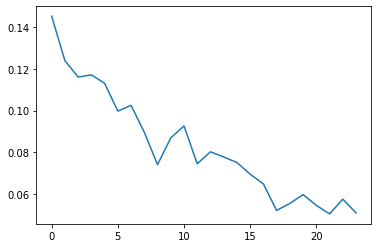

In [161]:
plt.plot(clf.history['loss'])

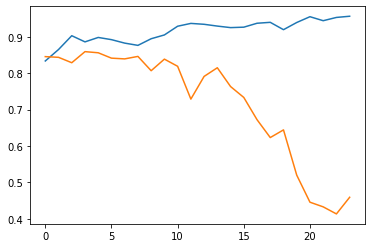

In [162]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

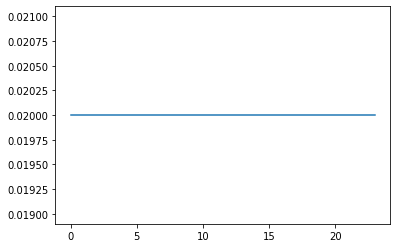

In [163]:
plt.plot(clf.history['lr'])

In [164]:
target = 'Class'

In [165]:
test_indices

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831],
           dtype='int64', length=7832)

In [166]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD2,LCS_STD2,...,OFL,FDA,GABOR,OCL_STD,LCS_STD,OFL_STD,FDA_STD,RVU,GABOR_STD,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,classOne,0.053521,0.092457,...,0.668878,0.450442,0.659029,0.082090,0.160900,0.297923,0.165506,0.533431,1.062037,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,classOne,0.052430,0.076413,...,0.656728,0.420273,0.581228,0.075764,0.141661,0.315187,0.147372,0.457116,0.990512,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,classOne,0.046736,0.119511,...,0.672784,0.417944,0.529954,0.096840,0.210623,0.291043,0.142840,0.505789,0.918927,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,classOne,0.063880,0.145236,...,0.709769,0.400578,0.283677,0.119394,0.230169,0.274530,0.134042,0.478189,0.662974,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,classOne,0.079128,0.228858,...,0.732113,0.436506,0.339123,0.129622,0.254241,0.262279,0.175556,0.459725,0.790986,0


In [167]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD2,LCS_STD2,...,OFL,FDA,GABOR,OCL_STD,LCS_STD,OFL_STD,FDA_STD,RVU,GABOR_STD,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,classOne,0.053521,0.092457,...,0.668878,0.450442,0.659029,0.082090,0.160900,0.297923,0.165506,0.533431,1.062037,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,classOne,0.052430,0.076413,...,0.656728,0.420273,0.581228,0.075764,0.141661,0.315187,0.147372,0.457116,0.990512,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,classOne,0.046736,0.119511,...,0.672784,0.417944,0.529954,0.096840,0.210623,0.291043,0.142840,0.505789,0.918927,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,classOne,0.063880,0.145236,...,0.709769,0.400578,0.283677,0.119394,0.230169,0.274530,0.134042,0.478189,0.662974,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,classOne,0.079128,0.228858,...,0.732113,0.436506,0.339123,0.129622,0.254241,0.262279,0.175556,0.459725,0.790986,0


In [168]:
test.head()

,Filename,White Circle Patch,Contrast,Black Patch,Biffercation,Termination,CID,Class,OCL_STD2,LCS_STD2,...,OFL,FDA,GABOR,OCL_STD,LCS_STD,OFL_STD,FDA_STD,RVU,GABOR_STD,Set
0,1443,5292.0,0.166200,0.976471,1509,403,332.053514,classOne,0.053521,0.092457,...,0.668878,0.450442,0.659029,0.082090,0.160900,0.297923,0.165506,0.533431,1.062037,0
1,1444,4175.5,0.098199,0.989966,1339,453,265.142266,classOne,0.052430,0.076413,...,0.656728,0.420273,0.581228,0.075764,0.141661,0.315187,0.147372,0.457116,0.990512,0
2,1445,5829.0,0.054095,0.996549,1679,472,293.976355,classOne,0.046736,0.119511,...,0.672784,0.417944,0.529954,0.096840,0.210623,0.291043,0.142840,0.505789,0.918927,0
3,1446,3193.5,0.024822,0.998801,1902,340,289.341544,classOne,0.063880,0.145236,...,0.709769,0.400578,0.283677,0.119394,0.230169,0.274530,0.134042,0.478189,0.662974,0
4,1447,3132.0,0.129463,0.985666,1132,296,314.832926,classOne,0.079128,0.228858,...,0.732113,0.436506,0.339123,0.129622,0.254241,0.262279,0.175556,0.459725,0.790986,0


In [169]:
features

['Filename',
 'White Circle Patch',
 'Contrast',
 'Black Patch',
 'Biffercation',
 'Termination',
 'CID',
 'OCL_STD2',
 'LCS_STD2',
 'OFL_STD2',
 'RPS',
 'FDA_STD2',
 'RVU_STD2',
 'GABOR_STD2',
 'GABORSHEN',
 'SIGMA',
 'MEAN',
 'OCL',
 'LCS',
 'OFL',
 'FDA',
 'GABOR',
 'OCL_STD',
 'LCS_STD',
 'OFL_STD',
 'FDA_STD',
 'RVU',
 'GABOR_STD']

In [170]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_test)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.858970700152207
FINAL TEST SCORE : 0.8552589885884809


In [171]:
clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classOne', 'classOne',
       'classOne'], dtype='<U9')

In [172]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [173]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [174]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.8552589885884809


In [175]:
assert(test_auc == loaded_test_auc)

In [176]:
loaded_clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classOne', 'classOne',
       'classOne'], dtype='<U9')

In [177]:
clf.feature_importances_

array([0.0071091 , 0.0186421 , 0.02808577, 0.01931728, 0.12106708,
       0.13634411, 0.12288682, 0.02417064, 0.00870137, 0.00562063,
       0.10363085, 0.00449328, 0.02731722, 0.0107096 , 0.00143972,
       0.14135471, 0.00417383, 0.02039137, 0.0106414 , 0.02654638,
       0.04617219, 0.02527696, 0.00903196, 0.03480468, 0.0028464 ,
       0.00827492, 0.00096308, 0.02998654])

In [178]:
explain_matrix, masks = clf.explain(X_test)

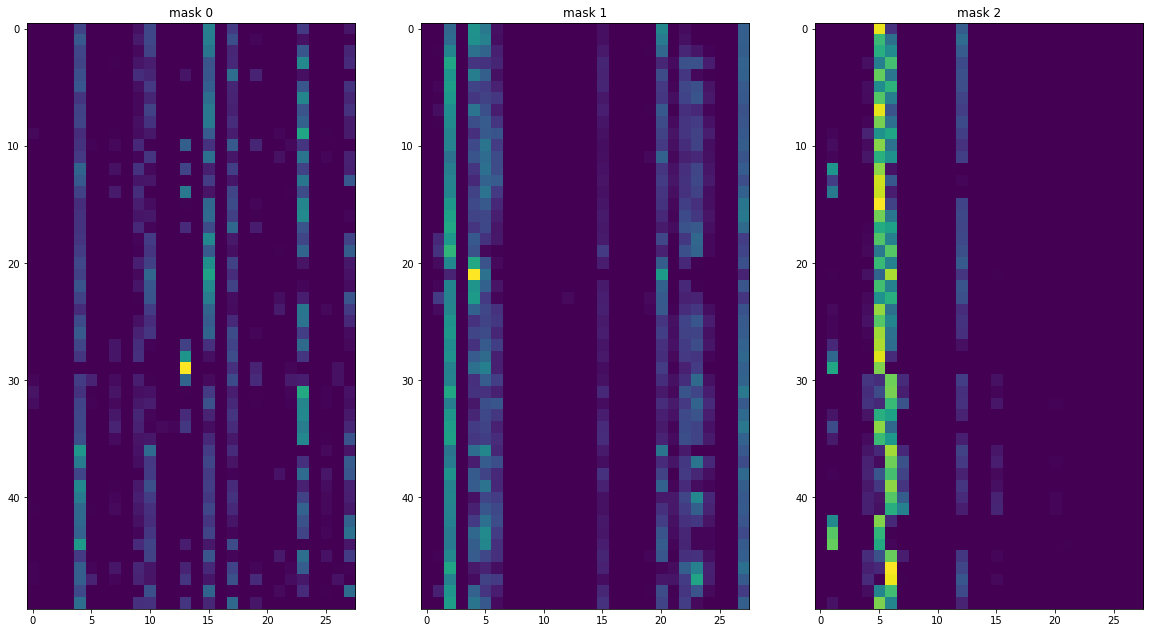

In [179]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")